# **Experiment one:**
For this experiment, we adress the following research questions

*   How important is word order for this task?
*   Does the tree structure help to get a better accuracy?

To address both questions we run the models: DeepBOW, LSTM and Tree-LSTM and compare their accuracies. We first tune the hyperparameters using validation sets and then we test them over 3 seeds to get the best models and mean accuracy on the test set.

To adress the question cooncerned with word order we compare the models DeepBow and LSTM and how they perform. To address the question regarding tree structure, we compare the LSTM and Tree structure as it builds on LSTM.

## Preparing the data

Let's first download the data set and take a look.

In [1]:
import re
import random
import time
import math
import numpy as np
import nltk
import matplotlib.pyplot as plt
plt.style.use('default')

In [2]:
!wget http://nlp.stanford.edu/sentiment/trainDevTestTrees_PTB.zip
!unzip trainDevTestTrees_PTB.zip

--2024-12-12 14:00:39--  http://nlp.stanford.edu/sentiment/trainDevTestTrees_PTB.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/sentiment/trainDevTestTrees_PTB.zip [following]
--2024-12-12 14:00:39--  https://nlp.stanford.edu/sentiment/trainDevTestTrees_PTB.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 789539 (771K) [application/zip]
Saving to: ‘trainDevTestTrees_PTB.zip’

trainDevTestTrees_P 100%[===================>] 771.03K  1017KB/s    in 0.8s    

2024-12-12 14:00:40 (1017 KB/s) - ‘trainDevTestTrees_PTB.zip’ saved [789539/789539]

Archive:  trainDevTestTrees_PTB.zip
   creating: trees/
  inflating: trees/dev.txt           
  inflating: trees/test.txt          
  inflating: trees/train.txt         


In [3]:
# this function reads in a textfile and fixes an issue with "\\"
def filereader(path):
  with open(path, mode="r", encoding="utf-8") as f:
    for line in f:
      yield line.strip().replace("\\","")

Let's look at a data point. It is a **flattened binary tree**, with sentiment scores at every node, and words as the leaves (or *terminal nodes*).

In [4]:
s = next(filereader("trees/dev.txt"))
print(s)

(3 (2 It) (4 (4 (2 's) (4 (3 (2 a) (4 (3 lovely) (2 film))) (3 (2 with) (4 (3 (3 lovely) (2 performances)) (2 (2 by) (2 (2 (2 Buy) (2 and)) (2 Accorsi))))))) (2 .)))


In [5]:
# We can use NLTK to better visualise the tree structure of the sentence
from nltk import Tree
from nltk.treeprettyprinter import TreePrettyPrinter
tree = Tree.fromstring(s)
print(TreePrettyPrinter(tree))

              3                                                                     
  ____________|____________________                                                  
 |                                 4                                                
 |        _________________________|______________________________________________   
 |       4                                                                        | 
 |    ___|______________                                                          |  
 |   |                  4                                                         | 
 |   |         _________|__________                                               |  
 |   |        |                    3                                              | 
 |   |        |               _____|______________________                        |  
 |   |        |              |                            4                       | 
 |   |        |              |            ________________|_

<ipython-input-5-6ab7e95feba4>:5: DeprecationWarning: 
    Class TreePrettyPrinter has been deprecated.  Import
    `TreePrettyPrinter` using `from nltk.tree import
    TreePrettyPrinter` instead.
  print(TreePrettyPrinter(tree))


The sentiment scores range from 0 (very negative) to 5 (very positive). Again, as you can see, every node in the tree is labeled with a sentiment score. For now, we will only use the score at the **root node**, i.e., the sentiment score for the complete sentence.

In [6]:
# Let's first make a function that extracts the tokens (the leaves).

def tokens_from_treestring(s):
  """extract the tokens from a sentiment tree"""
  return re.sub(r"\([0-9] |\)", "", s).split()

# let's try it on our example tree
tokens = tokens_from_treestring(s)
print(tokens)
print(len(tokens))

['It', "'s", 'a', 'lovely', 'film', 'with', 'lovely', 'performances', 'by', 'Buy', 'and', 'Accorsi', '.']
13


> *Warning: you could also parse a treestring using NLTK and ask it to return the leaves, but there seems to be an issue with NLTK not always correctly parsing the input, so do not rely on it.*

In [77]:
# We will also need the following function, but you can ignore this for now.
# It is explained later on.

SHIFT = 0
REDUCE = 1


def transitions_from_treestring(s):
  s = re.sub("\([0-5] ([^)]+)\)", "0", s)
  s = re.sub("\)", " )", s)
  s = re.sub("\([0-4] ", "", s)
  s = re.sub("\([0-4] ", "", s)
  s = re.sub("\)", "1", s)
  return list(map(int, s.split()))

In [8]:
# Now let's first see how large our data sets are.
for path in ("trees/train.txt", "trees/dev.txt", "trees/test.txt"):
  print("{:16s} {:4d}".format(path, sum(1 for _ in filereader(path))))

trees/train.txt  8544
trees/dev.txt    1101
trees/test.txt   2210


In [9]:
for path in ("trees/train.txt", "trees/dev.txt", "trees/test.txt"):
    print(f"First sentence in {path}:")
    print(next(filereader(path)))


First sentence in trees/train.txt:
(3 (2 (2 The) (2 Rock)) (4 (3 (2 is) (4 (2 destined) (2 (2 (2 (2 (2 to) (2 (2 be) (2 (2 the) (2 (2 21st) (2 (2 (2 Century) (2 's)) (2 (3 new) (2 (2 ``) (2 Conan)))))))) (2 '')) (2 and)) (3 (2 that) (3 (2 he) (3 (2 's) (3 (2 going) (3 (2 to) (4 (3 (2 make) (3 (3 (2 a) (3 splash)) (2 (2 even) (3 greater)))) (2 (2 than) (2 (2 (2 (2 (1 (2 Arnold) (2 Schwarzenegger)) (2 ,)) (2 (2 Jean-Claud) (2 (2 Van) (2 Damme)))) (2 or)) (2 (2 Steven) (2 Segal))))))))))))) (2 .)))
First sentence in trees/dev.txt:
(3 (2 It) (4 (4 (2 's) (4 (3 (2 a) (4 (3 lovely) (2 film))) (3 (2 with) (4 (3 (3 lovely) (2 performances)) (2 (2 by) (2 (2 (2 Buy) (2 and)) (2 Accorsi))))))) (2 .)))
First sentence in trees/test.txt:
(2 (3 (3 Effective) (2 but)) (1 (1 too-tepid) (2 biopic)))


You can see that the number of sentences is not very large. That's probably because the data set required so much manual annotation. However, it is large enough to train a neural network on.

It will be useful to store each data example in an `Example` object,
containing everything that we may need for each data point.
It will contain the tokens, the tree, the top-level sentiment label, and
the transitions (explained later).

In [10]:
from collections import namedtuple
from nltk import Tree

# A simple way to define a class is using namedtuple.
Example = namedtuple("Example", ["tokens", "tree", "label", "transitions"])


def examplereader(path, lower=False):
  """Returns all examples in a file one by one."""
  for line in filereader(path):
    line = line.lower() if lower else line
    tokens = tokens_from_treestring(line)
    tree = Tree.fromstring(line)  # use NLTK's Tree
    label = int(line[1])
    trans = transitions_from_treestring(line)
    yield Example(tokens=tokens, tree=tree, label=label, transitions=trans)


# Let's load the data into memory.
LOWER = False  # we will keep the original casing
train_data = list(examplereader("trees/train.txt", lower=LOWER))
dev_data = list(examplereader("trees/dev.txt", lower=LOWER))
test_data = list(examplereader("trees/test.txt", lower=LOWER))

print("train", len(train_data))
print("dev", len(dev_data))
print("test", len(test_data))

train 8544
dev 1101
test 2210


In [11]:
from collections import Counter
import matplotlib.pyplot as plt

# Function to count label distribution in the data
def count_labels(data):
    labels = [example.label for example in data]
    return Counter(labels)

# Count label distributions for train, dev, and test data
train_labels = count_labels(train_data)
dev_labels = count_labels(dev_data)
test_labels = count_labels(test_data)

print("Train Label Distribution:", train_labels)
print("Dev Label Distribution:", dev_labels)
print("Test Label Distribution:", test_labels)


Train Label Distribution: Counter({3: 2322, 1: 2218, 2: 1624, 4: 1288, 0: 1092})
Dev Label Distribution: Counter({1: 289, 3: 279, 2: 229, 4: 165, 0: 139})
Test Label Distribution: Counter({1: 633, 3: 510, 4: 399, 2: 389, 0: 279})


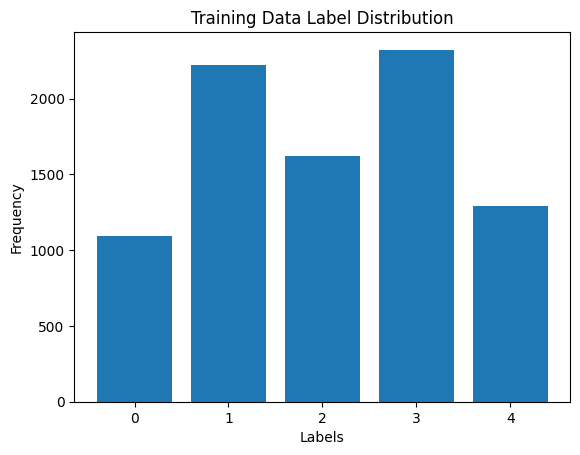

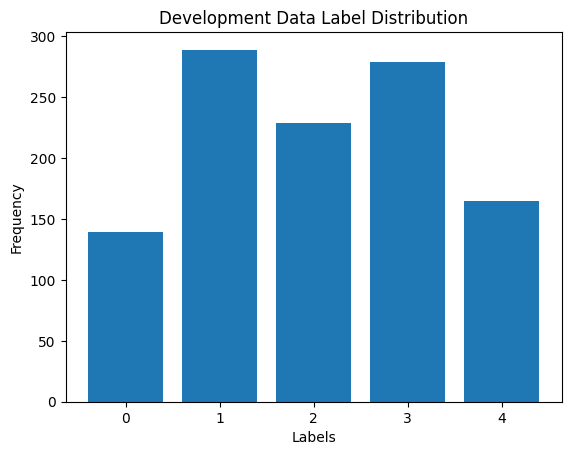

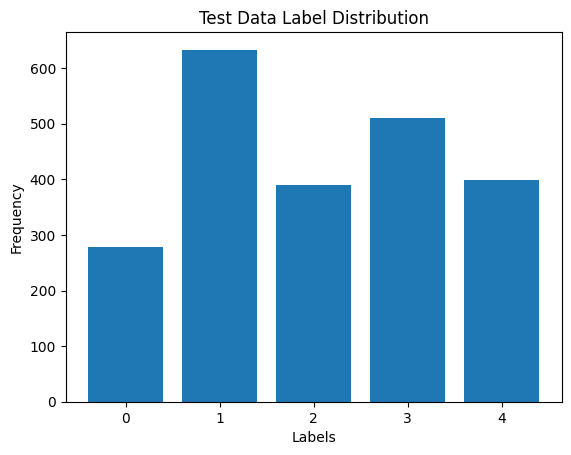

In [12]:
# Function to plot label distributions
def plot_label_distribution(label_counts, title):
    labels, counts = zip(*sorted(label_counts.items()))  # Sort by label for consistency
    plt.bar(labels, counts)
    plt.xlabel('Labels')
    plt.ylabel('Frequency')
    plt.title(title)
    plt.show()

# Plot distributions for train, dev, and test datasets
plot_label_distribution(train_labels, "Training Data Label Distribution")
plot_label_distribution(dev_labels, "Development Data Label Distribution")
plot_label_distribution(test_labels, "Test Data Label Distribution")


Let's check out an `Example` object.

#### Vocabulary
A first step in most NLP tasks is collecting all the word types that appear in the data into a vocabulary, and counting the frequency of their occurrences. On the one hand, this will give us an overview of the word distribution of the data set (what are the most frequent words, how many rare words are there, ...). On the other hand, we will also use the vocabulary to map each word to a unique numeric ID, which is a more handy index than a string.

In [13]:
# Here we first define a class that can map a word to an ID (w2i)
# and back (i2w).

from collections import Counter, OrderedDict, defaultdict


class OrderedCounter(Counter, OrderedDict):
  """Counter that remembers the order elements are first seen"""
  def __repr__(self):
    return '%s(%r)' % (self.__class__.__name__,
                      OrderedDict(self))
  def __reduce__(self):
    return self.__class__, (OrderedDict(self),)


class Vocabulary:
  """A vocabulary, assigns IDs to tokens"""

  def __init__(self):
    self.freqs = OrderedCounter()
    self.w2i = {}
    self.i2w = []

  def count_token(self, t):
    self.freqs[t] += 1

  def add_token(self, t):
    self.w2i[t] = len(self.w2i)
    self.i2w.append(t)

  def build(self, min_freq=0):
    '''
    min_freq: minimum number of occurrences for a word to be included
              in the vocabulary
    '''
    self.add_token("<unk>")  # reserve 0 for <unk> (unknown words)
    self.add_token("<pad>")  # reserve 1 for <pad> (discussed later)

    tok_freq = list(self.freqs.items())
    tok_freq.sort(key=lambda x: x[1], reverse=True)
    for tok, freq in tok_freq:
      if freq >= min_freq:
        self.add_token(tok)

The vocabulary has by default an `<unk>` token and a `<pad>` token. The `<unk>` token is reserved for all words which do not appear in the training data (and for which, therefore, we cannot learn word representations). The function of the `<pad>` token will be explained later.


Let's build the vocabulary!


In [14]:
# This process should be deterministic and should have the same result
# if run multiple times on the same data set.

v = Vocabulary()
for data_set in (train_data,):
  for ex in data_set:
    for token in ex.tokens:
      v.count_token(token)

v.build()
print("Vocabulary size:", len(v.w2i))

Vocabulary size: 18280


Let's have a closer look at the properties of our vocabulary. Having a good idea of what it is like can facilitate data analysis and debugging later on.

In [15]:
# Now let's map the sentiment labels 0-4 to a more readable form
i2t = ["very negative", "negative", "neutral", "positive", "very positive"]
print(i2t)
print(i2t[4])

['very negative', 'negative', 'neutral', 'positive', 'very positive']
very positive


In [16]:
# And let's also create the opposite mapping.
# We won't use a Vocabulary for this (although we could), since the labels
# are already numeric.
t2i = OrderedDict({p : i for p, i in zip(i2t, range(len(i2t)))})
print(t2i)
print(t2i['very positive'])

OrderedDict([('very negative', 0), ('negative', 1), ('neutral', 2), ('positive', 3), ('very positive', 4)])
4


## Set seed

In [17]:
def set_seed(seed):

    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

    # Enforce determinism in PyTorch
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


## PyTorch

We are going to need PyTorch and Google Colab does not have it installed by default. Run the cell below to install it.

*For installing PyTorch in your own computer, follow the instructions on [pytorch.org](pytorch.org) instead. This is for Google Colab only.*

In [18]:
import torch
print("Using torch", torch.__version__) # should say 1.7.0+cu101

Using torch 2.5.1+cu121


In [19]:
# Let's also import torch.nn, a PyTorch package that
# makes building neural networks more convenient.
from torch import nn

In [20]:
# PyTorch can run on CPU or on Nvidia GPU (video card) using CUDA
# This cell selects the GPU if one is available.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [21]:
# Seed manually to make runs reproducible
# You need to set this again if you do multiple runs of the same model
torch.manual_seed(42)

# When running on the CuDNN backend two further options must be set for reproducibility
if torch.cuda.is_available():
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

> **Hey, wait, where is the bias vector?**
> PyTorch does not print Parameters, only Modules!

> We can print it ourselves though, to check that it is there.

In [22]:

# Here we print each parameter name, shape, and if it is trainable.
def print_parameters(model):
  total = 0
  for name, p in model.named_parameters():
    total += np.prod(p.shape)
    print("{:24s} {:12s} requires_grad={}".format(name, str(list(p.shape)), p.requires_grad))
  print("\nTotal number of parameters: {}\n".format(total))


#print_parameters(bow_model)

#### Preparing an example for input

To feed sentences to our PyTorch model, we need to convert a sequence of tokens to a sequence of IDs. The `prepare_example` function below takes care of this for us. We then use these IDs as indices for the word embedding table.

In [23]:
def prepare_example(example, vocab):
  """
  Map tokens to their IDs for a single example
  """

  # vocab returns 0 if the word is not there (i2w[0] = <unk>)
  x = [vocab.w2i.get(t, 0) for t in example.tokens]

  x = torch.LongTensor([x])
  x = x.to(device)

  y = torch.LongTensor([example.label])
  y = y.to(device)

  return x, y

In [24]:
x, y = prepare_example(dev_data[0], v)
print('x:', x)
print('y:', y)

x: tensor([[  28,    9,    6,  998,   16,   18,  998,  135,   32, 7688,    5,    0,
            2]], device='cuda:0')
y: tensor([3], device='cuda:0')


# BOW

Our first model is a rather simple neural **bag-of-words (BOW) model**.
Unlike the bag-of-words model that you used in the previous lab, where we would look at the presence / frequency of words in a text, here we associate each word with a multi-dimensional vector which expresses what sentiment is conveyed by the word. In particular, our BOW vectors will be of size 5, exactly our number of sentiment classes.

To classify a sentence, we **sum** the vectors of the words in the sentence and a bias vector. Because we sum the vectors, we lose word order: that's why we call this a neural bag-of-words model.

```
this   [0.0, 0.1, 0.1, 0.1, 0.0]
movie  [0.0, 0.1, 0.1, 0.2, 0.1]
is     [0.0, 0.1, 0.0, 0.0, 0.0]
stupid [0.9, 0.5, 0.1, 0.0, 0.0]

bias   [0.0, 0.0, 0.0, 0.0, 0.0]
--------------------------------
sum    [0.9, 0.8, 0.3, 0.3, 0.1]

argmax: 0 (very negative)
```

The **argmax** of this sum is our predicted label.

We initialize all vectors *randomly* and train them using cross-entropy loss.

#### Model class

In [25]:
class BOW(nn.Module):
  """A simple bag-of-words model"""

  def __init__(self, vocab_size, embedding_dim, vocab):
    super(BOW, self).__init__()
    self.vocab = vocab

    # this is a trainable look-up table with word embeddings
    self.embed = nn.Embedding(vocab_size, embedding_dim)

    # this is a trainable bias term
    self.bias = nn.Parameter(torch.zeros(embedding_dim), requires_grad=True)

  def forward(self, inputs):
    # this is the forward pass of the neural network
    # it applies a function to the input and returns the output

    # this looks up the embeddings for each word ID in inputs
    # the result is a sequence of word embeddings
    embeds = self.embed(inputs)

    # the output is the sum across the time dimension (1)
    # with the bias term added
    logits = embeds.sum(1) + self.bias

    return logits

In [26]:
# Let's create a model.
vocab_size = len(v.w2i)
n_classes = len(t2i)
bow_model = BOW(vocab_size, n_classes, v)
print(bow_model)

BOW(
  (embed): Embedding(18280, 5)
)


#### Evaluation
We now need to define an evaluation metric.
How many predictions do we get right? The accuracy will tell us.
Make sure that you understand this code block.


In [27]:
def simple_evaluate(model, data, prep_fn=prepare_example, **kwargs):
    """Evaluate a model on a given data set and return y_true, y_pred, and accuracy."""
    y_true = []
    y_pred = []
    correct = 0
    total = 0
    model.eval()  # Disable dropout

    for example in data:
        # Convert the example input and label to PyTorch tensors
        x, target = prep_fn(example, model.vocab)

        # Forward pass without backpropagation (no_grad)
        with torch.no_grad():
            logits = model(x)

        # Get the prediction
        prediction = logits.argmax(dim=-1)

        # Collect true and predicted labels
        y_true.append(target.item())
        y_pred.append(prediction.item())

        # Calculate the number of correct predictions for accuracy
        correct += (prediction == target).sum().item()
        total += 1

    # Return all labels for additional metrics and the accuracy
    accuracy = correct / float(total)
    return y_true, y_pred, accuracy


We are using accuracy as a handy evaluation metric. Please consider using [alternative metrics](https://scikit-learn.org/stable/modules/classes.html#classification-metrics) for your experiments if that makes more theoretical sense.

#### Example feed
For stochastic gradient descent (SGD) we will need a random training example for every update.
We implement this by shuffling the training data and returning examples one by one using `yield`.

Shuffling is optional so that we get to use this function to get validation and test examples, too.

In [28]:
def get_examples(data, shuffle=True, **kwargs):
  """Shuffle data set and return 1 example at a time (until nothing left)"""
  if shuffle:
    print("Shuffling training data")
    random.shuffle(data)  # shuffle training data each epoch
  for example in data:
    yield example

#### Exercise: Training function

Your task is now to complete the training loop below.
Before you do so, please read the section about optimisation.

**Optimisation**

As mentioned in the "Intro to PyTorch" notebook, one of the perks of using PyTorch is automatic differentiation. We will use it to train our BOW model.

We train our model by feeding it an input, performing a **forward** pass, obtaining an output prediction, and calculating a **loss** with our loss function.
After the gradients are computed in the **backward** pass, we can take a step on the surface of the loss function towards more optimal parameter settings (gradient descent).

The package we will use to do this optimisation is [torch.optim](https://pytorch.org/docs/stable/optim.html).

In [29]:
from torch import optim

Besides implementations of stochastic gradient descent (SGD), this package also implements the optimisation algorithm Adam, which we'll be using in this practical.
For the purposes of this assignment you do not need to know what Adam does besides that it uses gradient information to update our model parameters by calling:

```
optimizer.step()
```
Remember when we updated our parameters in the PyTorch tutorial in a loop?


```python
# update weights
learning_rate = 0.5
for f in net.parameters():
    # for each parameter, take a small step in the opposite dir of the gradient
    p.data = p.data - p.grad.data * learning_rate

```
The function call optimizer.step() does effectively the same thing.

*(If you want to know more about optimisation algorithms using gradient information, [this blog](http://ruder.io/optimizing-gradient-descent/.) gives a nice intuitive overview.)*

In [97]:
def train_model(model, optimizer, num_iterations=10000,
                print_every=1000, eval_every=1000,
                batch_fn=get_examples,
                prep_fn=prepare_example,
                eval_fn=simple_evaluate,
                batch_size=1, eval_batch_size=None):
  """Train a model."""
  training_data = train_data[:]
  iter_i = 0
  train_loss = 0.
  print_num = 0
  start = time.time()
  criterion = nn.CrossEntropyLoss() # loss function
  best_eval = 0.
  best_iter = 0

  # store train loss and validation accuracy during training
  # so we can plot them afterwards
  losses = []
  accuracies = []

  if eval_batch_size is None:
    eval_batch_size = batch_size

  while True:  # when we run out of examples, shuffle and continue
    for batch in batch_fn(train_data, batch_size=batch_size):

      # forward pass
      model.train()
      x, targets = prep_fn(batch, model.vocab)
      logits = model(x)

      B = targets.size(0)  # later we will use B examples per update

      # compute cross-entropy loss (our criterion)
      # note that the cross entropy loss function computes the softmax for us
      loss = criterion(logits.view([B, -1]), targets.view(-1))
      train_loss += loss.item()

      # backward pass (tip: check the Introduction to PyTorch notebook)

      # erase previous gradients
      optimizer.zero_grad()

      # compute gradients
      loss.backward()

      # update weights - take a small step in the opposite dir of the gradient
      optimizer.step()


      print_num += 1
      iter_i += 1

      # print info
      if iter_i % print_every == 0:
        print("Iter %r: loss=%.4f, time=%.2fs" %
              (iter_i, train_loss, time.time()-start))
        losses.append(train_loss)
        print_num = 0
        train_loss = 0.

      # evaluate
      if iter_i % eval_every == 0:
        _, _, accuracy = eval_fn(model, dev_data, batch_size=eval_batch_size,
                                 batch_fn=batch_fn, prep_fn=prep_fn)
        accuracies.append(accuracy)
        print("iter %r: dev acc=%.4f" % (iter_i, accuracy))

        # save best model parameters
        if accuracy > best_eval:
          print("new highscore")
          best_eval = accuracy
          best_iter = iter_i
          path = "{}.pt".format(model.__class__.__name__)
          ckpt = {
              "state_dict": model.state_dict(),
              "optimizer_state_dict": optimizer.state_dict(),
              "best_eval": best_eval,
              "best_iter": best_iter
          }
          torch.save(ckpt, path)

      # done training
      if iter_i == num_iterations:
        print("Done training")

        # evaluate on train, dev, and test with best model
        print("Loading best model")
        path = "{}.pt".format(model.__class__.__name__)
        ckpt = torch.load(path)
        model.load_state_dict(ckpt["state_dict"])

        _, _, train_acc = eval_fn(
            model, train_data, batch_size=eval_batch_size,
            batch_fn=batch_fn, prep_fn=prep_fn)
        _, _, dev_acc = eval_fn(
            model, dev_data, batch_size=eval_batch_size,
            batch_fn=batch_fn, prep_fn=prep_fn)
        _, _, test_acc = eval_fn(
            model, test_data, batch_size=eval_batch_size,
            batch_fn=batch_fn, prep_fn=prep_fn)

        print("best model iter {:d}: "
              "train acc={:.4f}, dev acc={:.4f}, test acc={:.4f}".format(
                  best_iter, train_acc, dev_acc, test_acc))

        return losses, accuracies, test_acc

### Training the BOW model

In [31]:
seeds = [42, 123, 999]
test_accuracies_bow = []

for seed in seeds:
    set_seed(seed)

    # If everything is in place we can now train our first model!
    bow_model = BOW(len(v.w2i), len(t2i), vocab=v)

    bow_model = bow_model.to(device)

    # Initialize optimizer
    optimizer = torch.optim.Adam(bow_model.parameters(), lr=0.0005)

    bow_losses, bow_accuracies, test_acc = train_model(
    bow_model, optimizer, num_iterations=30000,
    print_every=250, eval_every=250)

    print(f"Best Test Accuracy for seed {seed}: {test_acc:.4f}")
    test_accuracies_bow.append(test_acc)

Shuffling training data
Iter 250: loss=1328.0669, time=1.24s
iter 250: dev acc=0.1935
new highscore
Iter 500: loss=1307.1405, time=1.87s
iter 500: dev acc=0.1926
Iter 750: loss=1481.4087, time=2.45s
iter 750: dev acc=0.1853
Iter 1000: loss=1392.0646, time=3.02s
iter 1000: dev acc=0.1907
Iter 1250: loss=1348.1545, time=3.58s
iter 1250: dev acc=0.1916
Iter 1500: loss=1196.0284, time=4.15s
iter 1500: dev acc=0.1916
Iter 1750: loss=1280.2403, time=4.72s
iter 1750: dev acc=0.1953
new highscore
Iter 2000: loss=1150.3451, time=5.30s
iter 2000: dev acc=0.1944
Iter 2250: loss=1152.3489, time=5.86s
iter 2250: dev acc=0.1935
Iter 2500: loss=1108.7458, time=6.44s
iter 2500: dev acc=0.1907
Iter 2750: loss=1137.3586, time=7.01s
iter 2750: dev acc=0.1898
Iter 3000: loss=1289.1320, time=7.58s
iter 3000: dev acc=0.1926
Iter 3250: loss=1089.3906, time=8.15s
iter 3250: dev acc=0.1926
Iter 3500: loss=1212.3204, time=8.73s
iter 3500: dev acc=0.1926
Iter 3750: loss=1123.5985, time=9.31s
iter 3750: dev acc=0

<ipython-input-30-07f34c5b57a1>:91: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(path)


best model iter 28500: train acc=0.3071, dev acc=0.2398, test acc=0.2443
Best Test Accuracy for seed 42: 0.2443
Shuffling training data
Iter 250: loss=1234.9920, time=0.26s
iter 250: dev acc=0.1862
new highscore
Iter 500: loss=1271.1098, time=0.81s
iter 500: dev acc=0.1880
new highscore
Iter 750: loss=1365.2055, time=1.37s
iter 750: dev acc=0.1889
new highscore
Iter 1000: loss=1288.1588, time=1.93s
iter 1000: dev acc=0.1871
Iter 1250: loss=1263.3492, time=2.49s
iter 1250: dev acc=0.1880
Iter 1500: loss=1312.0686, time=3.05s
iter 1500: dev acc=0.1916
new highscore
Iter 1750: loss=1124.6366, time=3.63s
iter 1750: dev acc=0.1898
Iter 2000: loss=1253.6047, time=4.19s
iter 2000: dev acc=0.1889
Iter 2250: loss=1241.2774, time=4.75s
iter 2250: dev acc=0.1907
Iter 2500: loss=1206.1156, time=5.31s
iter 2500: dev acc=0.1935
new highscore
Iter 2750: loss=1156.0051, time=5.88s
iter 2750: dev acc=0.1953
new highscore
Iter 3000: loss=1196.7076, time=6.44s
iter 3000: dev acc=0.1980
new highscore
Iter

In [32]:
# Compute mean and standard deviation across seeds
mean_accuracy = np.mean(test_accuracies_bow)
std_accuracy = np.std(test_accuracies_bow)
print(f"Mean Test Accuracy: {mean_accuracy:.4f}")
print(f"Standard Deviation: {std_accuracy:.4f}")


Mean Test Accuracy: 0.2543
Standard Deviation: 0.0141


# CBOW

We now continue with a **continuous bag-of-words (CBOW)** model. (*This is not the same as the word2vec CBOW model!*)

It is similar to the BOW model above, but now embeddings can have a dimension of *arbitrary size*.
This means that we can choose a higher dimensionality and learn more aspects of each word. We will still sum word vectors to get a sentence representation, but now the size of the resulting vector will no longer correspond to the number of sentiment classes.

So to turn the size of our summed vector into the number of output classes, we can *learn* a parameter matrix $W$ and multiply it by the sum vector $x$: $$Wx$$
If the size of $x$ is `d x 1`, we can set $W$ to be `5 x d`, so that the output of the matrix multiplication will be the of the desired size, `5 x 1`. Then, just like for the BOW model, we can obtain a prediction using the argmax function.

## Exercise: implement and train the CBOW model

Write a class `CBOW` that:

- has word embeddings with size 300
- sums the word vectors for the input words (just like in `BOW`)
- projects the resulting vector down to 5 units using a linear layer and a bias term (check out `nn.Linear`)

Train your CBOW model and plot the validation accuracy and training loss over time.

In [33]:
import torch
import torch.nn as nn

class CBOW(nn.Module):
    def __init__(self, vocab_size, num_classes, vocab, embedding_dim=300):
        """
        CBOW Model
        """
        super(CBOW, self).__init__()

        # 1. Embedding layer: maps word indices to 300-dimensional vectors
        self.embed = nn.Embedding(vocab_size, embedding_dim)

        # 2. Linear layer: projects the sentence vector (embedding_dim) to output logits (num_classes)
        self.fc = nn.Linear(embedding_dim, num_classes)

        self.vocab = vocab

    def forward(self, x):
        """
        Forward pass of the CBOW model
        """
        # 1. Look up embeddings for each word in the input
        embeddings = self.embed(x)  # Shape: [batch_size, seq_len, embedding_dim]

        # 2. Sum embeddings along the sequence length dimension
        sentence_vector = embeddings.sum(dim=1)  # Shape: [batch_size, embedding_dim]

        # 3. Project the sentence vector to logits using the linear layer
        logits = self.fc(sentence_vector)  # Shape: [batch_size, num_classes]

        return logits

In [34]:
seeds = [42, 123, 999]
test_accuracies_cbow = []

for seed in seeds:
    set_seed(seed)

    # If everything is in place we can now train our first model!
    cbow_model = CBOW(len(v.w2i), len(t2i), vocab=v)

    cbow_model = cbow_model.to(device)
    optimizer = optim.Adam(cbow_model.parameters(), lr=0.0005)

    losses, accuracies, test_acc = train_model(
    cbow_model, optimizer, num_iterations=20000,
    print_every=100, eval_every=100)

    print(f"Best Test Accuracy for seed {seed}: {test_acc:.4f}")
    test_accuracies_cbow.append(test_acc)



Shuffling training data
Iter 100: loss=335.1990, time=0.30s
iter 100: dev acc=0.2134
new highscore
Iter 200: loss=306.0141, time=0.88s
iter 200: dev acc=0.2080
Iter 300: loss=323.9237, time=1.35s
iter 300: dev acc=0.2053
Iter 400: loss=239.8090, time=1.83s
iter 400: dev acc=0.2153
new highscore
Iter 500: loss=243.7179, time=2.46s
iter 500: dev acc=0.2225
new highscore
Iter 600: loss=315.6823, time=3.14s
iter 600: dev acc=0.2361
new highscore
Iter 700: loss=247.9935, time=3.77s
iter 700: dev acc=0.2343
Iter 800: loss=258.4768, time=4.24s
iter 800: dev acc=0.2307
Iter 900: loss=225.4629, time=4.72s
iter 900: dev acc=0.2298
Iter 1000: loss=238.0346, time=5.20s
iter 1000: dev acc=0.2407
new highscore
Iter 1100: loss=236.9075, time=5.81s
iter 1100: dev acc=0.2480
new highscore
Iter 1200: loss=208.1920, time=6.44s
iter 1200: dev acc=0.2652
new highscore
Iter 1300: loss=240.5668, time=7.05s
iter 1300: dev acc=0.2543
Iter 1400: loss=256.0918, time=7.52s
iter 1400: dev acc=0.2625
Iter 1500: los

<ipython-input-30-07f34c5b57a1>:91: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(path)


best model iter 19500: train acc=0.5652, dev acc=0.3370, test acc=0.3561
Best Test Accuracy for seed 42: 0.3561
Shuffling training data
Iter 100: loss=340.0605, time=0.14s
iter 100: dev acc=0.2144
new highscore
Iter 200: loss=283.7693, time=0.76s
iter 200: dev acc=0.2035
Iter 300: loss=266.3839, time=1.24s
iter 300: dev acc=0.2089
Iter 400: loss=312.4178, time=1.71s
iter 400: dev acc=0.2035
Iter 500: loss=285.2600, time=2.19s
iter 500: dev acc=0.2225
new highscore
Iter 600: loss=226.9294, time=2.84s
iter 600: dev acc=0.2080
Iter 700: loss=220.8995, time=3.31s
iter 700: dev acc=0.2271
new highscore
Iter 800: loss=285.7745, time=3.95s
iter 800: dev acc=0.2062
Iter 900: loss=256.4001, time=4.43s
iter 900: dev acc=0.2325
new highscore
Iter 1000: loss=258.4729, time=5.08s
iter 1000: dev acc=0.2371
new highscore
Iter 1100: loss=255.0116, time=5.71s
iter 1100: dev acc=0.2316
Iter 1200: loss=256.5278, time=6.19s
iter 1200: dev acc=0.2461
new highscore
Iter 1300: loss=203.2188, time=6.81s
iter 

In [35]:
# Compute mean and standard deviation across seeds
mean_accuracy = np.mean(test_accuracies_cbow)
std_accuracy = np.std(test_accuracies_cbow)
print(f"Mean Test Accuracy: {mean_accuracy:.4f}")
print(f"Standard Deviation: {std_accuracy:.4f}")

Mean Test Accuracy: 0.3380
Standard Deviation: 0.0130


# Deep CBOW

To see if we can squeeze some more performance out of the CBOW model, we can make it deeper and non-linear by adding more layers and, e.g., tanh-activations.
By using more parameters we can learn more aspects of the data, and by using more layers and non-linearities, we can try to learn a more complex function.
This is not something that always works. If the input-output mapping of your data is simple, then a complicated function could easily overfit on your training set, thereby leading to poor generalization.

#### Exercise: write Deep CBOW class and train it

Write a class `DeepCBOW`.

In your code, make sure that your `output_layer` consists of the following:
- A linear transformation from E units to D units.
- A Tanh activation
- A linear transformation from D units to D units
- A Tanh activation
- A linear transformation from D units to 5 units (our output classes).

E is the size of the word embeddings (please use E=300) and D for the size of a hidden layer (please use D=100).

We recommend using [nn.Sequential](https://pytorch.org/docs/stable/nn.html?highlight=sequential#torch.nn.Sequential) to implement this exercise.

In [47]:
import torch
import torch.nn as nn

class DeepCBOW(nn.Module):
    def __init__(self, vocab_size, num_classes, vocab, embedding_dim=300, hidden_dim=100):
        """
        Deep CBOW Model
        :param vocab_size: Size of the vocabulary
        :param num_classes: Number of output classes
        :param embedding_dim: Size of the word embeddings (E)
        :param hidden_dim: Size of the hidden layers (D)
        """
        super(DeepCBOW, self).__init__()
        self.vocab = vocab # Add this line to store the vocabulary

        # Embedding layer: Map word indices to embedding vectors
        self.embed = nn.Embedding(vocab_size, embedding_dim)

        # Output layer: Stack of linear layers + tanh activations
        self.output_layer = nn.Sequential(
            nn.Linear(embedding_dim, hidden_dim),  # E -> D
            nn.Tanh(),                            # Non-linearity
            nn.Linear(hidden_dim, hidden_dim),    # D -> D
            nn.Tanh(),                            # Non-linearity
            nn.Linear(hidden_dim, num_classes)    # D -> 5
        )

    def forward(self, x):
        """
        Forward pass of the Deep CBOW model
        :param x: Input word indices (batch_size, seq_len)
        :return: Logits (batch_size, num_classes)
        """
        # 1. Look up embeddings for each word in the input
        embeddings = self.embed(x)  # Shape: [batch_size, seq_len, embedding_dim]

        # 2. Sum embeddings along the sequence length dimension
        sentence_vector = embeddings.sum(dim=1)  # Shape: [batch_size, embedding_dim]

        # 3. Pass through the output layer
        logits = self.output_layer(sentence_vector)  # Shape: [batch_size, num_classes]

        return logits

In [49]:
seeds = [42, 123, 999]
test_accuracies_dcbow = []

for seed in seeds:
    set_seed(seed)

    # If everything is in place we can now train our first model!
    dcbow_model = DeepCBOW(len(v.w2i), num_classes = 5, vocab = v)

    dcbow_model = dcbow_model.to(device)
    optimizer = optim.Adam(dcbow_model.parameters(), lr=0.0005)

    losses, accuracies, test_acc = train_model(
    dcbow_model, optimizer, num_iterations=13000,
    print_every=100, eval_every=100)

    print(f"Best Test Accuracy for seed {seed}: {test_acc:.4f}")
    test_accuracies_dcbow.append(test_acc)


Shuffling training data
Iter 100: loss=157.8315, time=0.18s
iter 100: dev acc=0.2598
new highscore
Iter 200: loss=156.2704, time=1.01s
iter 200: dev acc=0.2489
Iter 300: loss=160.0996, time=1.69s
iter 300: dev acc=0.2534
Iter 400: loss=155.9718, time=2.32s
iter 400: dev acc=0.2661
new highscore
Iter 500: loss=159.3816, time=3.12s
iter 500: dev acc=0.2507
Iter 600: loss=163.3096, time=3.76s
iter 600: dev acc=0.2425
Iter 700: loss=156.3889, time=4.39s
iter 700: dev acc=0.2679
new highscore
Iter 800: loss=157.5715, time=5.17s
iter 800: dev acc=0.2843
new highscore
Iter 900: loss=156.9384, time=5.99s
iter 900: dev acc=0.2861
new highscore
Iter 1000: loss=168.1795, time=6.80s
iter 1000: dev acc=0.2552
Iter 1100: loss=163.5461, time=7.43s
iter 1100: dev acc=0.2616
Iter 1200: loss=162.5178, time=8.06s
iter 1200: dev acc=0.2616
Iter 1300: loss=155.8191, time=8.69s
iter 1300: dev acc=0.2525
Iter 1400: loss=160.4076, time=9.32s
iter 1400: dev acc=0.2607
Iter 1500: loss=151.0670, time=9.96s
iter 

<ipython-input-30-07f34c5b57a1>:91: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(path)


best model iter 12700: train acc=0.4709, dev acc=0.3569, test acc=0.3701
Best Test Accuracy for seed 42: 0.3701
Shuffling training data
Iter 100: loss=165.7891, time=0.18s
iter 100: dev acc=0.2543
new highscore
Iter 200: loss=163.7531, time=0.98s
iter 200: dev acc=0.2507
Iter 300: loss=159.4045, time=1.61s
iter 300: dev acc=0.2707
new highscore
Iter 400: loss=164.4126, time=2.46s
iter 400: dev acc=0.2561
Iter 500: loss=157.7531, time=3.10s
iter 500: dev acc=0.2834
new highscore
Iter 600: loss=147.0043, time=3.90s
iter 600: dev acc=0.2779
Iter 700: loss=159.0828, time=4.54s
iter 700: dev acc=0.2925
new highscore
Iter 800: loss=164.8504, time=5.37s
iter 800: dev acc=0.2743
Iter 900: loss=154.8687, time=6.01s
iter 900: dev acc=0.2943
new highscore
Iter 1000: loss=151.7906, time=6.84s
iter 1000: dev acc=0.2952
new highscore
Iter 1100: loss=161.3168, time=7.67s
iter 1100: dev acc=0.2725
Iter 1200: loss=158.1875, time=8.31s
iter 1200: dev acc=0.2743
Iter 1300: loss=163.0278, time=8.96s
iter 

In [ ]:
    # Compute mean and standard deviation across seeds
    mean_accuracy = np.mean(test_accuracies_dcbow)
    std_accuracy = np.std(test_accuracies_dcbow)
    print(f"Mean Test Accuracy: {mean_accuracy:.4f}")
    print(f"Standard Deviation: {std_accuracy:.4f}")

# Pre-trained word embeddings

The Stanford Sentiment Treebank is a rather small data set, since it required fine-grained manual annotatation. This makes it difficult for the Deep CBOW model to learn good word embeddings, i.e. to learn good word representations for the words in our vocabulary.
In fact, the only error signal that the network receives is from predicting the sentiment of entire sentences!

To start off with better word representations, we can download **pre-trained word embeddings**.
You can choose which pre-trained word embeddings to use:

- **GloVe**. The "original" Stanford Sentiment classification [paper](http://aclweb.org/anthology/P/P15/P15-1150.pdf) used Glove embeddings, which are just another method (like *word2vec*) to get word embeddings from unannotated text. Glove is described in the following paper which you should cite if you use them:
> Jeffrey Pennington, Richard Socher, and Christopher Manning. ["Glove: Global vectors for word representation."](https://nlp.stanford.edu/pubs/glove.pdf) EMNLP 2014.

- **Word2Vec**. This is the method that you learned about in class, described in:
> Mikolov, Tomas, et al. ["Distributed representations of words and phrases and their compositionality."](https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf) Advances in neural information processing systems. 2013.

Using these pre-trained word embeddings, we can initialize our word embedding lookup table and start form a point where similar words are already close to one another in the distributional semantic space.

You can choose to keep the word embeddings **fixed** or to train them further, specialising them to the task at hand.
We will keep them fixed for now.

For the purposes of this lab, it is enough if you understand how word2vec works (whichever vectors you use), but if you are interested, we encourage you to also check out the GloVe paper.

You can either download the word2vec vectors, or the Glove vectors.
If you want to compare your results to the Stanford paper later on, then you should use Glove.
**At the end of this lab you have the option to compare which vectors give you the best performance. For now, simply choose one of them and continue with that.**

[**OPTIONAL in case you don't want to mount Google Drive:** instead of running all the 5 boxes below, you can 1) download the GloVe and word2vec in your local machine, 2) upload them on your Drive folder ("My Drive"). Then, uncomment the first 2 lines in box 6 before writing your code!]


In [50]:
import requests

# URL to the glove file
url = "https://gist.githubusercontent.com/bastings/b094de2813da58056a05e8e7950d4ad1/raw/3fbd3976199c2b88de2ae62afc0ecc6f15e6f7ce/glove.840B.300d.sst.txt"

# File name to save the downloaded file
file_name = "glove.filtered.txt"

# Download the file
print("Downloading glove file...")
response = requests.get(url)

# Save the file locally
with open(file_name, "wb") as f:
    f.write(response.content)

print(f"File downloaded and saved as {file_name}")

File downloaded and saved as glove.filtered.txt


In [51]:
# Parse the Word2Vec file
glove = {}
with open("glove.filtered.txt", "r", encoding="utf-8") as f:
    for line in f:
        values = line.strip().split()
        word = values[0]  # The first value is the word
        vector = [float(x) for x in values[1:]]  # The rest are the embedding values
        glove[word] = vector

print(f"Loaded {len(glove)} word embeddings!")


from collections import defaultdict
import numpy as np

# Initialize vocabulary object
v = Vocabulary()

# Add special tokens manually
v.add_token("<unk>")
v.add_token("<pad>")

# Define embedding dimensions and initialize list for vectors
embedding_dim = 300  # Update if using different dimensions
vectors = []

# Add special token embeddings
vectors.append(np.random.uniform(-0.01, 0.01, embedding_dim))  # <unk>
vectors.append(np.zeros(embedding_dim))  # <pad>

# Add pre-trained word embeddings to vocabulary
for word, vector in glove.items():
    if word not in v.w2i:  # If the word is not already in the vocab
        v.add_token(word)
        vectors.append(vector)

# Convert vectors to a NumPy array
vectors = np.stack(vectors, axis=0)

# Print vocabulary size and first few entries
print(f"Vocabulary size: {len(v.w2i)}")
print("First 10 vocabulary entries:")
for i, word in enumerate(v.i2w[:10]):
    print(f"{i}: {word}")


Loaded 20725 word embeddings!
Vocabulary size: 20727
First 10 vocabulary entries:
0: <unk>
1: <pad>
2: ,
3: .
4: the
5: and
6: to
7: of
8: a
9: in


In [52]:
import torch
import torch.nn as nn

class DeepCBOW(nn.Module):
    def __init__(self, vocab_size, vocab, num_classes, embedding_dim=300, hidden_dim=100):
        """
        Deep CBOW Model
        :param vocab_size: Size of the vocabulary
        :param num_classes: Number of output classes
        :param embedding_dim: Size of the word embeddings (E)
        :param hidden_dim: Size of the hidden layers (D)
        """
        super(DeepCBOW, self).__init__()

        # Embedding layer: Map word indices to embedding vectors
        self.embed = nn.Embedding(vocab_size, embedding_dim)

        # Output layer: Stack of linear layers + tanh activations
        self.output_layer = nn.Sequential(
            nn.Linear(embedding_dim, hidden_dim),  # E -> D
            nn.Tanh(),                            # Non-linearity
            nn.Linear(hidden_dim, hidden_dim),    # D -> D
            nn.Tanh(),                            # Non-linearity
            nn.Linear(hidden_dim, num_classes)    # D -> 5
        )

    def forward(self, x):
        """
        Forward pass of the Deep CBOW model
        :param x: Input word indices (batch_size, seq_len)
        :return: Logits (batch_size, num_classes)
        """
        # 1. Look up embeddings for each word in the input
        embeddings = self.embed(x)  # Shape: [batch_size, seq_len, embedding_dim]

        # 2. Sum embeddings along the sequence length dimension
        sentence_vector = embeddings.sum(dim=1)  # Shape: [batch_size, embedding_dim]

        # 3. Pass through the output layer
        logits = self.output_layer(sentence_vector)  # Shape: [batch_size, num_classes]

        return logits


#### Exercise: train Deep CBOW with (fixed) pre-trained embeddings

Now train Deep CBOW again using the pre-trained word vectors.


Create a function to set set for reproducbility.

In [53]:
# We define a new class that inherits from DeepCBOW.
class PTDeepCBOW(DeepCBOW):
  def __init__(self, vocab_size, vocab, output_dim, embedding_dim, hidden_dim):
    super(PTDeepCBOW, self).__init__(
        vocab_size, vocab, output_dim, embedding_dim, hidden_dim)
    self.vocab = vocab

In [54]:
seeds = [42, 123, 999]
test_accuracies = []

for seed in seeds:
    set_seed(seed)

    # Initialize model
    model = PTDeepCBOW(
        vocab_size=len(v.w2i),
        vocab=v,
        embedding_dim=300,
        hidden_dim=100,
        output_dim=5
    ).to(device)
    model.embed.weight.data.copy_(torch.from_numpy(vectors))
    model.embed.weight.requires_grad = False  # Freeze pre-trained embeddings

    # Initialize optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

    # Train model
    losses, accuracies, test_acc = train_model(
        model=model,
        optimizer=optimizer,
        num_iterations=30000,  # Number of training iterations
        print_every=1000,      # Print loss every 1000 iterations
        eval_every=1000,       # Evaluate on validation set every 1000 iterations
        batch_fn=get_examples, # Your batch generation function
        prep_fn=prepare_example,
        eval_fn=simple_evaluate,
        batch_size=32,         # Training batch size
        eval_batch_size=64     # Validation/test batch size
    )

    print(f"Best Test Accuracy for seed {seed}: {test_acc:.4f}")
    test_accuracies.append(test_acc)

Shuffling training data
Iter 1000: loss=1455.3107, time=1.55s
iter 1000: dev acc=0.3942
new highscore
Iter 2000: loss=1390.2019, time=3.59s
iter 2000: dev acc=0.3470
Iter 3000: loss=1388.0997, time=5.58s
iter 3000: dev acc=0.4005
new highscore
Iter 4000: loss=1351.8830, time=7.61s
iter 4000: dev acc=0.4169
new highscore
Iter 5000: loss=1358.7709, time=9.65s
iter 5000: dev acc=0.4160
Iter 6000: loss=1348.6428, time=11.66s
iter 6000: dev acc=0.3969
Iter 7000: loss=1290.5094, time=13.67s
iter 7000: dev acc=0.4178
new highscore
Iter 8000: loss=1356.0794, time=15.72s
iter 8000: dev acc=0.4105
Shuffling training data
Iter 9000: loss=1329.9029, time=17.70s
iter 9000: dev acc=0.4078
Iter 10000: loss=1301.8730, time=19.68s
iter 10000: dev acc=0.3960
Iter 11000: loss=1298.8526, time=21.68s
iter 11000: dev acc=0.4096
Iter 12000: loss=1327.6230, time=23.69s
iter 12000: dev acc=0.4169
Iter 13000: loss=1293.6260, time=25.68s
iter 13000: dev acc=0.4015
Iter 14000: loss=1298.6122, time=27.66s
iter 140

<ipython-input-30-07f34c5b57a1>:91: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(path)


best model iter 23000: train acc=0.4686, dev acc=0.4387, test acc=0.4534
Best Test Accuracy for seed 42: 0.4534
Shuffling training data
Iter 1000: loss=1497.4186, time=1.55s
iter 1000: dev acc=0.3924
new highscore
Iter 2000: loss=1393.2240, time=3.62s
iter 2000: dev acc=0.3860
Iter 3000: loss=1335.4659, time=5.63s
iter 3000: dev acc=0.4005
new highscore
Iter 4000: loss=1351.2476, time=7.72s
iter 4000: dev acc=0.3851
Iter 5000: loss=1340.8471, time=9.71s
iter 5000: dev acc=0.3678
Iter 6000: loss=1299.4600, time=11.70s
iter 6000: dev acc=0.4051
new highscore
Iter 7000: loss=1363.5977, time=13.71s
iter 7000: dev acc=0.4287
new highscore
Iter 8000: loss=1364.0745, time=15.73s
iter 8000: dev acc=0.4205
Shuffling training data
Iter 9000: loss=1323.9758, time=17.78s
iter 9000: dev acc=0.4169
Iter 10000: loss=1293.4403, time=19.78s
iter 10000: dev acc=0.4151
Iter 11000: loss=1318.1495, time=21.78s
iter 11000: dev acc=0.3797
Iter 12000: loss=1287.7797, time=23.77s
iter 12000: dev acc=0.4087
Ite

In [ ]:
# Compute mean and standard deviation across seeds
mean_accuracy = np.mean(test_accuracies)
std_accuracy = np.std(test_accuracies)
print(f"Mean Test Accuracy: {mean_accuracy:.4f}")
print(f"Standard Deviation: {std_accuracy:.4f}")

# LSTM

In [56]:
class MyLSTMCell(nn.Module):
  """Our own LSTM cell"""

  def __init__(self, input_size, hidden_size, bias=True):
    """Creates the weights for this LSTM"""
    super(MyLSTMCell, self).__init__()

    self.input_size = input_size
    self.hidden_size = hidden_size
    self.bias = bias

# Define weights for input gates
    self.W_ii = nn.Parameter(torch.Tensor(hidden_size, input_size))
    self.W_if = nn.Parameter(torch.Tensor(hidden_size, input_size))
    self.W_ig = nn.Parameter(torch.Tensor(hidden_size, input_size))
    self.W_io = nn.Parameter(torch.Tensor(hidden_size, input_size))

        # Define weights for hidden state gates
    self.W_hi = nn.Parameter(torch.Tensor(hidden_size, hidden_size))
    self.W_hf = nn.Parameter(torch.Tensor(hidden_size, hidden_size))
    self.W_hg = nn.Parameter(torch.Tensor(hidden_size, hidden_size))
    self.W_ho = nn.Parameter(torch.Tensor(hidden_size, hidden_size))

        # Define biases
    self.b_i = nn.Parameter(torch.Tensor(hidden_size))
    self.b_f = nn.Parameter(torch.Tensor(hidden_size))
    self.b_g = nn.Parameter(torch.Tensor(hidden_size))
    self.b_o = nn.Parameter(torch.Tensor(hidden_size))


    self.reset_parameters()

  def reset_parameters(self):
    """This is PyTorch's default initialization method"""
    stdv = 1.0 / math.sqrt(self.hidden_size)
    for weight in self.parameters():
      weight.data.uniform_(-stdv, stdv)

  def forward(self, input_, hx, mask=None):
    """
    input is (batch, input_size)
    hx is ((batch, hidden_size), (batch, hidden_size))
    """
    prev_h, prev_c = hx

    # Compute the input gate
    i = torch.sigmoid(
            torch.mm(input_, self.W_ii.T) + torch.mm(prev_h, self.W_hi.T) + self.b_i
        )
    # Compute the forget gate
    f = torch.sigmoid(
        torch.mm(input_, self.W_if.T) + torch.mm(prev_h, self.W_hf.T) + self.b_f
    )
    # Compute the candidate cell state
    g = torch.tanh(
        torch.mm(input_, self.W_ig.T) + torch.mm(prev_h, self.W_hg.T) + self.b_g
    )
     # Compute the output gate
    o = torch.sigmoid(
        torch.mm(input_, self.W_io.T) + torch.mm(prev_h, self.W_ho.T) + self.b_o
    )

        # Update the cell state
    c = f * prev_c + i * g

        # Compute the hidden state
    h = o * torch.tanh(c)

    return h, c

  def __repr__(self):
    return "{}({:d}, {:d})".format(
        self.__class__.__name__, self.input_size, self.hidden_size)

#### LSTM Classifier

Having an LSTM cell is not enough: we still need some code that calls it repeatedly, and then makes a prediction from the final hidden state.
You will find that code below. Make sure that you understand it.

In [57]:
class LSTMClassifier(nn.Module):
  """Encodes sentence with an LSTM and projects final hidden state"""

  def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, vocab):
    super(LSTMClassifier, self).__init__()
    self.vocab = vocab
    self.hidden_dim = hidden_dim
    self.embed = nn.Embedding(vocab_size, embedding_dim, padding_idx=1)
    self.rnn = MyLSTMCell(embedding_dim, hidden_dim)

    self.output_layer = nn.Sequential(
        nn.Dropout(p=0.5),  # explained later
        nn.Linear(hidden_dim, output_dim)
    )

  def forward(self, x):

    B = x.size(0)  # batch size (this is 1 for now, i.e. 1 single example)
    T = x.size(1)  # timesteps (the number of words in the sentence)

    input_ = self.embed(x)

    # here we create initial hidden states containing zeros
    # we use a trick here so that, if input is on the GPU, then so are hx and cx
    hx = input_.new_zeros(B, self.rnn.hidden_size)
    cx = input_.new_zeros(B, self.rnn.hidden_size)

    # process input sentences one word/timestep at a time
    # input is batch-major (i.e., batch size is the first dimension)
    # so the first word(s) is (are) input_[:, 0]
    outputs = []
    for i in range(T):
      hx, cx = self.rnn(input_[:, i], (hx, cx))
      outputs.append(hx)

    # if we have a single example, our final LSTM state is the last hx
    if B == 1:
      final = hx
    else:
      #
      # This part is explained in next section, ignore this else-block for now.
      #
      # We processed sentences with different lengths, so some of the sentences
      # had already finished and we have been adding padding inputs to hx.
      # We select the final state based on the length of each sentence.

      # two lines below not needed if using LSTM from pytorch
      outputs = torch.stack(outputs, dim=0)           # [T, B, D]
      outputs = outputs.transpose(0, 1).contiguous()  # [B, T, D]

      # to be super-sure we're not accidentally indexing the wrong state
      # we zero out positions that are invalid
      pad_positions = (x == 1).unsqueeze(-1)

      outputs = outputs.contiguous()
      outputs = outputs.masked_fill_(pad_positions, 0.)

      mask = (x != 1)  # true for valid positions [B, T]
      lengths = mask.sum(dim=1)                 # [B, 1]

      indexes = (lengths - 1) + torch.arange(B, device=x.device, dtype=x.dtype) * T
      final = outputs.view(-1, self.hidden_dim)[indexes]  # [B, D]

    # we use the last hidden state to classify the sentence
    logits = self.output_layer(final)
    return logits

# Mini-batching



In [58]:
def get_minibatch(data, batch_size=25, shuffle=True):
  """Return minibatches, optional shuffling"""

  if shuffle:
    print("Shuffling training data")
    random.shuffle(data)  # shuffle training data each epoch

  batch = []

  # yield minibatches
  for example in data:
    batch.append(example)

    if len(batch) == batch_size:
      yield batch
      batch = []

  # in case there is something left
  if len(batch) > 0:
    yield batch

#### Padding function
We will need a function that adds padding 1s to a sequence of IDs so that
it becomes as long as the longest sequence in the minibatch.

In [59]:
def pad(tokens, length, pad_value=1):
  """add padding 1s to a sequence to that it has the desired length"""
  return tokens + [pad_value] * (length - len(tokens))

# example
tokens = [2, 3, 4]
pad(tokens, 5)

[2, 3, 4, 1, 1]

#### New `prepare` function

We will also need a new function that turns a mini-batch into PyTorch tensors.

In [60]:
def prepare_minibatch(mb, vocab):
  """
  Minibatch is a list of examples.
  This function converts words to IDs and returns
  torch tensors to be used as input/targets.
  """
  batch_size = len(mb)
  maxlen = max([len(ex.tokens) for ex in mb])

  # vocab returns 0 if the word is not there
  x = [pad([vocab.w2i.get(t, 0) for t in ex.tokens], maxlen) for ex in mb]

  x = torch.LongTensor(x)
  x = x.to(device)

  y = [ex.label for ex in mb]
  y = torch.LongTensor(y)
  y = y.to(device)

  return x, y

In [61]:
# Let's test our new function.
# This should give us 3 examples.
mb = next(get_minibatch(train_data, batch_size=3, shuffle=False))

In [62]:
# We should find padding 1s at the end
x, y = prepare_minibatch(mb, v)

#### Evaluate (mini-batch version)

We can now update our evaluation function to use mini-batches

In [63]:
def evaluate(model, data,
             batch_fn=get_minibatch, prep_fn=prepare_minibatch,
             batch_size=16):
  """Accuracy of a model on given data set (using mini-batches)"""
  correct = 0
  total = 0
  model.eval()  # disable dropout

  for mb in batch_fn(data, batch_size=batch_size, shuffle=False):
    x, targets = prep_fn(mb, model.vocab)
    with torch.no_grad():
      logits = model(x)

    predictions = logits.argmax(dim=-1).view(-1)

    # add the number of correct predictions to the total correct
    correct += (predictions == targets.view(-1)).sum().item()
    total += targets.size(0)

  return correct, total, correct / float(total)

# LSTM (Mini-batched)

With this, let's run the LSTM again but now using mini-batches!

In [64]:
seeds = [42, 123, 999]
lstm_test_accuracies = []

for seed in seeds:
  set_seed(seed)

  lstm_model = LSTMClassifier(
  len(v.w2i), 300, 168, len(t2i), v)

  # copy pre-trained vectors into embeddings table
  with torch.no_grad():
    lstm_model.embed.weight.data.copy_(torch.from_numpy(vectors))
    lstm_model.embed.weight.requires_grad = False

  print(lstm_model)
  print_parameters(lstm_model)

  lstm_model = lstm_model.to(device)

  batch_size = 25
  optimizer = optim.Adam(lstm_model.parameters(), lr=3e-4)

  lstm_losses, lstm_accuracies, best_acc = train_model( lstm_model, optimizer, num_iterations=1710,
  print_every=250, eval_every=250,
  batch_size=batch_size,
  batch_fn=get_minibatch,
  prep_fn=prepare_minibatch,
  eval_fn=evaluate)

  print(f"Best Test Accuracy for seed {seed}: {best_acc:.4f}")
  lstm_test_accuracies.append(best_acc)

LSTMClassifier(
  (embed): Embedding(20727, 300, padding_idx=1)
  (rnn): MyLSTMCell(300, 168)
  (output_layer): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=168, out_features=5, bias=True)
  )
)
embed.weight             [20727, 300] requires_grad=False
rnn.W_ii                 [168, 300]   requires_grad=True
rnn.W_if                 [168, 300]   requires_grad=True
rnn.W_ig                 [168, 300]   requires_grad=True
rnn.W_io                 [168, 300]   requires_grad=True
rnn.W_hi                 [168, 168]   requires_grad=True
rnn.W_hf                 [168, 168]   requires_grad=True
rnn.W_hg                 [168, 168]   requires_grad=True
rnn.W_ho                 [168, 168]   requires_grad=True
rnn.b_i                  [168]        requires_grad=True
rnn.b_f                  [168]        requires_grad=True
rnn.b_g                  [168]        requires_grad=True
rnn.b_o                  [168]        requires_grad=True
output_layer.1.weight    [5, 

<ipython-input-30-07f34c5b57a1>:91: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(path)


best model iter 1250: train acc=0.4837, dev acc=0.4423, test acc=0.4629
Best Test Accuracy for seed 42: 0.4629
LSTMClassifier(
  (embed): Embedding(20727, 300, padding_idx=1)
  (rnn): MyLSTMCell(300, 168)
  (output_layer): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=168, out_features=5, bias=True)
  )
)
embed.weight             [20727, 300] requires_grad=False
rnn.W_ii                 [168, 300]   requires_grad=True
rnn.W_if                 [168, 300]   requires_grad=True
rnn.W_ig                 [168, 300]   requires_grad=True
rnn.W_io                 [168, 300]   requires_grad=True
rnn.W_hi                 [168, 168]   requires_grad=True
rnn.W_hf                 [168, 168]   requires_grad=True
rnn.W_hg                 [168, 168]   requires_grad=True
rnn.W_ho                 [168, 168]   requires_grad=True
rnn.b_i                  [168]        requires_grad=True
rnn.b_f                  [168]        requires_grad=True
rnn.b_g                  [168]  

In [65]:
# Compute mean and standard deviation across seeds
mean_accuracy = np.mean(lstm_test_accuracies)
std_accuracy = np.std(lstm_test_accuracies)
print(f"Mean Test Accuracy: {mean_accuracy:.4f}")
print(f"Standard Deviation: {std_accuracy:.4f}")

Mean Test Accuracy: 0.4575
Standard Deviation: 0.0061


## Fine tune word embeddings

In [66]:
seeds = [42, 123, 999]
lstm_test_accuracies_em = []

for seed in seeds:
  set_seed(seed)
  lstm_model = LSTMClassifier(
  len(v.w2i), 300, 168, len(t2i), v)

  # copy pre-trained vectors into embeddings table
  with torch.no_grad():
    lstm_model.embed.weight.data.copy_(torch.from_numpy(vectors))

  lstm_model.embed.weight.requires_grad = True

# Now fine-tune your embeddings together with the model

  print(lstm_model)
  print_parameters(lstm_model)

  lstm_model = lstm_model.to(device)

  batch_size = 25
  optimizer = optim.Adam([
    {"params": lstm_model.embed.parameters(), "lr":0.1},       # Fine-tune embeddings with a lower LR
    {"params": lstm_model.rnn.parameters(), "lr": 3e-4},
    {"params": lstm_model.output_layer.parameters(), "lr": 3e-4} # Higher LR for the classifier
])
  lstm_losses, lstm_accuracies, best_acc = train_model(
    lstm_model, optimizer, num_iterations=1710,
    print_every=250, eval_every=250,
    batch_size=batch_size,
    batch_fn=get_minibatch,
    prep_fn=prepare_minibatch,
    eval_fn=evaluate)

  print(f"Best Test Accuracy for seed {seed}: {best_acc:.4f}")
  lstm_test_accuracies_em.append(best_acc)

LSTMClassifier(
  (embed): Embedding(20727, 300, padding_idx=1)
  (rnn): MyLSTMCell(300, 168)
  (output_layer): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=168, out_features=5, bias=True)
  )
)
embed.weight             [20727, 300] requires_grad=True
rnn.W_ii                 [168, 300]   requires_grad=True
rnn.W_if                 [168, 300]   requires_grad=True
rnn.W_ig                 [168, 300]   requires_grad=True
rnn.W_io                 [168, 300]   requires_grad=True
rnn.W_hi                 [168, 168]   requires_grad=True
rnn.W_hf                 [168, 168]   requires_grad=True
rnn.W_hg                 [168, 168]   requires_grad=True
rnn.W_ho                 [168, 168]   requires_grad=True
rnn.b_i                  [168]        requires_grad=True
rnn.b_f                  [168]        requires_grad=True
rnn.b_g                  [168]        requires_grad=True
rnn.b_o                  [168]        requires_grad=True
output_layer.1.weight    [5, 1

<ipython-input-30-07f34c5b57a1>:91: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(path)


best model iter 500: train acc=0.7870, dev acc=0.3669, test acc=0.3828
Best Test Accuracy for seed 42: 0.3828
LSTMClassifier(
  (embed): Embedding(20727, 300, padding_idx=1)
  (rnn): MyLSTMCell(300, 168)
  (output_layer): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=168, out_features=5, bias=True)
  )
)
embed.weight             [20727, 300] requires_grad=True
rnn.W_ii                 [168, 300]   requires_grad=True
rnn.W_if                 [168, 300]   requires_grad=True
rnn.W_ig                 [168, 300]   requires_grad=True
rnn.W_io                 [168, 300]   requires_grad=True
rnn.W_hi                 [168, 168]   requires_grad=True
rnn.W_hf                 [168, 168]   requires_grad=True
rnn.W_hg                 [168, 168]   requires_grad=True
rnn.W_ho                 [168, 168]   requires_grad=True
rnn.b_i                  [168]        requires_grad=True
rnn.b_f                  [168]        requires_grad=True
rnn.b_g                  [168]    

In [96]:
mean_accuracy = np.mean(lstm_test_accuracies_em)
std_accuracy = np.std(lstm_test_accuracies_em)

print(f"Mean Test Accuracy: {mean_accuracy:.4f}")
print(f"Standard Deviation: {std_accuracy:.4f}")

Mean Test Accuracy: 0.3715
Standard Deviation: 0.0096


# Tree-LSTM

## Computation

Do you remember the `transitions_from_treestring` function all the way in the beginning of this lab? Every example contains a **transition sequence** produced by this function. Let's look at it again:



In the final part of this lab we will exploit the tree structure of the SST data.
Until now we only used the surface tokens, but remember that our data examples include binary trees with a sentiment score at every node.

In particular, we will implement **N-ary Tree-LSTMs** which are described in:

> Kai Sheng Tai, Richard Socher, and Christopher D. Manning. [Improved Semantic Representations From Tree-Structured Long Short-Term Memory Networks](http://aclweb.org/anthology/P/P15/P15-1150.pdf) ACL 2015.

Since our trees are binary (i.e., N=2), we can refer to these as *Binary Tree-LSTMs*. If you study equations (9) to (14) in the paper, you will find that they are not all too different from the original LSTM that you already have.

You should read this paper carefully and make sure that you understand the approach. You will also find our LSTM baseline there.
Note however that Tree-LSTMs were proposed around the same time by two other groups:

> Phong Le and Willem Zuidema. [Compositional distributional semantics with long short term memory](http://anthology.aclweb.org/S/S15/S15-1002.pdf). *SEM 2015.

> Xiaodan Zhu, Parinaz Sobihani,  and Hongyu Guo. [Long short-term memory over recursive structures](http://proceedings.mlr.press/v37/zhub15.pdf). ICML 2015.

It is good scientific practice to cite all three papers in your report.




## Computation

Do you remember the `transitions_from_treestring` function all the way in the beginning of this lab? Every example contains a **transition sequence** produced by this function. Let's look at it again:



In [85]:
ex = next(examplereader("trees/train.txt"))
print(TreePrettyPrinter(ex.tree))
print("Transitions:")
print(ex.transitions)

                                                                                               3                                                                                                                                         
      _________________________________________________________________________________________|____                                                                                                                                      
     |                                                                                              4                                                                                                                                    
     |                      ________________________________________________________________________|__________________________________________________________________________________________________________________________________   
     |                     3                                  

<ipython-input-85-a3509d08ee20>:2: DeprecationWarning: 
    Class TreePrettyPrinter has been deprecated.  Import
    `TreePrettyPrinter` using `from nltk.tree import
    TreePrettyPrinter` instead.
  print(TreePrettyPrinter(ex.tree))


Note that the tree is **binary**. Every node has two children, except for pre-terminal nodes.

A tree like this can be described by a sequence of **SHIFT (0)** and **REDUCE (1)** actions.

To construct a tree, we can use the transitions as follows:
- **reverse** the sentence (a list of tokens) and call this the **buffer**
   - the first word is now on top (last in the list), and we would get it when calling pop() on the buffer
- create an empty list and call it the **stack**
- iterate through the transition sequence:
  - if it says SHIFT(0), we pop a word from the buffer, and push it to the stack
  - if it says REDUCE(1), we pop the **top two items** from the stack, and combine them (e.g. with a Tree-LSTM!), creating a new node that we push back on the stack
  
Convince yourself that going through the transition sequence above will result in the tree that you see.
For example, we would start by putting the following words on the stack (by shifting 5 times, starting with `It`):

```
Top of the stack:
-----------------
film
lovely
a
's  
It
```
Now we find a REDUCE in the transition sequence, so we get the top two words (film and lovely), and combine them, so our new stack becomes:
```
Top of the stack:
-----------------
lovely film
a
's  
It
```

We will use this approach when encoding sentences with our Tree-LSTM.
Now, our sentence is a reversed list of word embeddings.
When we shift, we move a word embedding to the stack.
When we reduce, we apply the Tree-LSTM to the top two vectors, and the result is a single vector that we put back on the stack.
After going through the whole transition sequence, we will have the root node on our stack! We can use that to classify the sentence.



## Obtaining the transition sequence



So what goes on in the `transitions_from_treestring` function?

The idea ([explained in this blog post](https://devblogs.nvidia.com/recursive-neural-networks-pytorch/)) is that, if we had a tree, we could traverse through the tree, and every time that we find a node containing only a word, we output a SHIFT.
Every time **after** we have finished visiting the children of a node, we output a REDUCE.
(What is this tree traversal called?)

However, our `transitions_from_treestring` function operates directly on the string representation. It works as follows.

We start with the representation:

```
(3 (2 It) (4 (4 (2 's) (4 (3 (2 a) (4 (3 lovely) (2 film))) (3 (2 with) (4 (3 (3 lovely) (2 performances)) (2 (2 by) (2 (2 (2 Buy) (2 and)) (2 Accorsi))))))) (2 .)))
```

First we remove pre-terminal nodes (and add spaces before closing brackets):

```
(3 It (4 (4 's (4 (3 a (4 lovely film ) ) (3 with (4 (3 lovely performances ) (2 by (2 (2 Buy and )  Accorsi ) ) ) ) ) ) . ) )
```

Then we remove node labels:

```
( It ( ( 's ( ( a ( lovely film ) ) ( with ( ( lovely performances) ( by ( ( Buy and )  Accorsi ) ) ) ) ) ) . ) )
```

Then we remove opening brackets:

```
It 's a lovely film ) ) with lovely performances ) by Buy and ) Accorsi ) ) ) ) ) ) . ) )
```

Now we replace words by S (for SHIFT), and closing brackets by R (for REDUCE):

```
S S S S S R R S S S R S S S R S R R R R R R S R R
0 0 0 0 0 1 1 0 0 0 1 0 0 0 1 0 1 1 1 1 1 1 0 1 1
```

Et voilà. We just obtained the transition sequence!

In [86]:
# for comparison
seq = ex.transitions
s = " ".join(["S" if t == 0 else "R" for t in seq])
print(s)
print(" ".join(map(str, seq)))

S S R S S S S S S S S R S S S R R R R R R R S R S R S S S S S S S S R S S R R R S S S R S R S S S R R R S R S S R R R R R R R R R R R R S R R
0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 1 1 1 1 1 1 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 1 1 1 0 0 0 1 0 1 0 0 0 1 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1


## Coding the Tree-LSTM

The code below contains a Binary Tree-LSTM cell.
It is used in the TreeLSTM class below it, which in turn is used in the TreeLSTMClassifier.
The job of the TreeLSTM class is to encode a complete sentence and return the root node.
The job of the TreeLSTMCell is to return a new state when provided with two children (a reduce action). By repeatedly calling the TreeLSTMCell, the TreeLSTM will encode a sentence. This can be done for multiple sentences at the same time.


#### Exercise
Check the `forward` function and complete the Tree-LSTM formulas.
You can see that we defined a large linear layer for you, that projects the *concatenation* of the left and right child into the input gate, left forget gate, right forget gate, candidate, and output gate.

In [87]:
class TreeLSTMCell(nn.Module):
  """A Binary Tree LSTM cell"""

  def __init__(self, input_size, hidden_size, bias=True):
    """Creates the weights for this LSTM"""
    super(TreeLSTMCell, self).__init__()

    self.input_size = input_size
    self.hidden_size = hidden_size
    self.bias = bias

    self.reduce_layer = nn.Linear(2 * hidden_size, 5 * hidden_size)
    self.dropout_layer = nn.Dropout(p=0.25)

    self.reset_parameters()

  def reset_parameters(self):
    """This is PyTorch's default initialization method"""
    stdv = 1.0 / math.sqrt(self.hidden_size)
    for weight in self.parameters():
      weight.data.uniform_(-stdv, stdv)

  def forward(self, hx_l, hx_r, mask=None):
    """
    hx_l is ((batch, hidden_size), (batch, hidden_size))
    hx_r is ((batch, hidden_size), (batch, hidden_size))
    """
    prev_h_l, prev_c_l = hx_l  # left child
    prev_h_r, prev_c_r = hx_r  # right child

    B = prev_h_l.size(0)

    # we concatenate the left and right children
    # you can also project from them separately and then sum
    children = torch.cat([prev_h_l, prev_h_r], dim=1)

    # project the combined children into a 5D tensor for i,fl,fr,g,o
    # this is done for speed, and you could also do it separately
    proj = self.reduce_layer(children)  # shape: B x 5D

    # each shape: B x D
    i, f_l, f_r, g, o = torch.chunk(proj, 5, dim=-1)

    # main Tree LSTM computation
    # The shape of each of these is [batch_size, hidden_size]

    # Apply activations
    i = torch.sigmoid(i)          # Input gate
    f_l = torch.sigmoid(f_l)      # Left forget gate
    f_r = torch.sigmoid(f_r)      # Right forget gate
    g = torch.tanh(g)             # Candidate memory
    o = torch.sigmoid(o)          # Output gate

    # Compute the new cell state
    c = i * g + f_l * prev_c_l + f_r * prev_c_r

    # Compute the new hidden state
    h = o * torch.tanh(c)

    return h, c

  def __repr__(self):
    return "{}({:d}, {:d})".format(
        self.__class__.__name__, self.input_size, self.hidden_size)

## Explanation of the TreeLSTM class


The code below contains the TreeLSTM class, which implements everything we need in order to encode a sentence from word embeddings. The calculations are the same as in the paper, implemented such that the class `TreeLSTMCell` above is as general as possible and only takes two children to reduce them into a parent.


**Initialize $\mathbf{h}$ and $\mathbf{c}$ outside of the cell for the leaves**

At the leaves of each tree the children nodes are **empty**, whereas in higher levels the nodes are binary tree nodes that *do* have a left and right child (but no input $x$). By initializing the leaf nodes outside of the cell class (`TreeLSTMCell`), we avoid if-else statements in the forward pass.

The `TreeLSTM` class (among other things) pre-calculates an initial $h$ and $c$ for every word in the sentence. Since the initial left and right child are 0, the only calculations we need to do are based on $x$, and we can drop the forget gate calculation (`prev_c_l` and `prev_c_r` are zero). The calculations we do in order to initalize $h$ and $c$ are then:

$$
c_1 =  W^{(u)}x_1 \\
o_1 = \sigma (W^{(i)}x_1) \\
h_1 = o_1 \odot \text{tanh}(c_1)$$
*NB: note that these equations are chosen as initializations of $c$ and $h$, other initializations are possible and might work equally well.*

**Sentence Representations**

All our leaf nodes are now initialized, so we can start processing the sentence in its tree form. Each sentence is represented by a buffer (initially a list with a concatenation of $[h_1, c_1]$ for every word in the reversed sentence), a stack (initially an empty list) and a transition sequence. To encode our sentence, we construct the tree from its transition sequence as explained earlier.

*A short example that constructs a tree:*

We loop over the time dimension of the batched transition sequences (i.e. row by row), which contain values of 0's, 1's and 2's (representing SHIFT, REDUCE and padding respectively). If we have a batch of size 2 where the first example has a transition sequence given by [0, 0, 1, 0, 0, 0, 1] and the second by [0, 0, 1, 0, 0, 1], our transition batch will be given by the following two-dimensional numpy array:

$$
\text{transitions} =
\begin{pmatrix}
0 & 0\\
0 & 0\\
1 & 1\\
0 & 0\\
0 & 0\\
0 & 1\\
1 & 2
\end{pmatrix}
$$
The inner loop (`for transition, buffer, stack in zip(t_batch, buffers, stacks)`) goes over each example in the batch and updates its buffer and stack. The nested loop for this example will then do roughy the following:

```
Time = 0:  t_batch = [0, 0], the inner loop performs 2 SHIFTs.

Time = 1:  t_batch = [0, 0], ".."

Time = 2:  t_batch = [1, 1], causing the inner loop to fill the list child_l and child_r for both examples in the batch. Now the statement if child_l will return True, triggering a REDUCE action to be performed by our Tree LSTM cell with a batch size of 2.

Time = 3:  t_batch = [0, 0], "..".

Time = 4:  t_batch = [0, 0], ".."

Time = 5:  t_batch = [0, 1], one SHIFT will be done and another REDUCE action will be performed by our Tree LSTM, this time of batch size 1.  

Time = 6:  t_batch = [1, 2], triggering another REDUCE action with batch size 1.
```
*NB: note that this was an artificial example for the purpose of demonstrating parts of the code, the transition sequences do not necessarily represent actual trees.*

**Batching and Unbatching**

Within the body of the outer loop over time, we use the functions for batching and unbatching.

*Batching*

Before passing two lists of children to the reduce layer (an instance of `TreeLSTMCell`), we batch the children as they are at this point a list of tensors of variable length based on how many REDUCE actions there are to perform at a certain time step across the batch (let's call the length `L`). To do an efficient forward pass we want to transform the list to a pair of tensors of shape `([L, D], [L, D])`, which the function `batch` achieves.

*Unbatching*

In the same line where we batched the children, we unbatch the output of the forward pass to become a list of states of length `L` again. We do this because we need to loop over each example's transition at the current time step and push the children that are reduced into a parent to the stack.

*The batch and unbatch functions let us switch between the "PyTorch world" (Tensors) and the Python world (easy to manipulate lists).*


In [88]:
# Helper functions for batching and unbatching states
# For speed we want to combine computations by batching, but
# for processing logic we want to turn the output into lists again
# to easily manipulate.

def batch(states):
  """
  Turns a list of states into a single tensor for fast processing.
  This function also chunks (splits) each state into a (h, c) pair"""
  return torch.cat(states, 0).chunk(2, 1)

def unbatch(state):
  """
  Turns a tensor back into a list of states.
  First, (h, c) are merged into a single state.
  Then the result is split into a list of sentences.
  """
  return torch.split(torch.cat(state, 1), 1, 0)

Take some time to understand the class below, having read the explanation above.

In [89]:
class TreeLSTM(nn.Module):
  """Encodes a sentence using a TreeLSTMCell"""

  def __init__(self, input_size, hidden_size, bias=True):
    """Creates the weights for this LSTM"""
    super(TreeLSTM, self).__init__()

    self.input_size = input_size
    self.hidden_size = hidden_size
    self.bias = bias
    self.reduce = TreeLSTMCell(input_size, hidden_size)

    # project word to initial c
    self.proj_x = nn.Linear(input_size, hidden_size)
    self.proj_x_gate = nn.Linear(input_size, hidden_size)

    self.buffers_dropout = nn.Dropout(p=0.5)

  def forward(self, x, transitions):
    """
    WARNING: assuming x is reversed!
    :param x: word embeddings [B, T, E]
    :param transitions: [2T-1, B]
    :return: root states
    """

    B = x.size(0)  # batch size
    T = x.size(1)  # time

    # compute an initial c and h for each word
    # Note: this corresponds to input x in the Tai et al. Tree LSTM paper.
    # We do not handle input x in the TreeLSTMCell itself.
    buffers_c = self.proj_x(x)
    buffers_h = buffers_c.tanh()
    buffers_h_gate = self.proj_x_gate(x).sigmoid()
    buffers_h = buffers_h_gate * buffers_h

    # concatenate h and c for each word
    buffers = torch.cat([buffers_h, buffers_c], dim=-1)

    D = buffers.size(-1) // 2

    # we turn buffers into a list of stacks (1 stack for each sentence)
    # first we split buffers so that it is a list of sentences (length B)
    # then we split each sentence to be a list of word vectors
    buffers = buffers.split(1, dim=0)  # Bx[T, 2D]
    buffers = [list(b.squeeze(0).split(1, dim=0)) for b in buffers]  # BxTx[2D]

    # create B empty stacks
    stacks = [[] for _ in buffers]

    # t_batch holds 1 transition for each sentence
    for t_batch in transitions:

      child_l = []  # contains the left child for each sentence with reduce action
      child_r = []  # contains the corresponding right child

      # iterate over sentences in the batch
      # each has a transition t, a buffer and a stack
      for transition, buffer, stack in zip(t_batch, buffers, stacks):
        if transition == SHIFT:
          stack.append(buffer.pop())
        elif transition == REDUCE:
          assert len(stack) >= 2, \
            "Stack too small! Should not happen with valid transition sequences"
          child_r.append(stack.pop())  # right child is on top
          child_l.append(stack.pop())

      # if there are sentences with reduce transition, perform them batched
      if child_l:
        reduced = iter(unbatch(self.reduce(batch(child_l), batch(child_r))))
        for transition, stack in zip(t_batch, stacks):
          if transition == REDUCE:
            stack.append(next(reduced))

    final = [stack.pop().chunk(2, -1)[0] for stack in stacks]
    final = torch.cat(final, dim=0)  # tensor [B, D]

    return final

Just like the LSTM before, we will need an extra class that does the classifications.

In [90]:
class TreeLSTMClassifier(nn.Module):
  """Encodes sentence with a TreeLSTM and projects final hidden state"""

  def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, vocab):
    super(TreeLSTMClassifier, self).__init__()
    self.vocab = vocab
    self.hidden_dim = hidden_dim
    self.embed = nn.Embedding(vocab_size, embedding_dim, padding_idx=1)
    self.treelstm = TreeLSTM(embedding_dim, hidden_dim)
    self.output_layer = nn.Sequential(
        nn.Dropout(p=0.5),
        nn.Linear(hidden_dim, output_dim, bias=True)
    )

  def forward(self, x):

    # x is a pair here of words and transitions; we unpack it here.
    # x is batch-major: [B, T], transitions is time major [2T-1, B]
    x, transitions = x
    emb = self.embed(x)

    # we use the root/top state of the Tree LSTM to classify the sentence
    root_states = self.treelstm(emb, transitions)

    # we use the last hidden state to classify the sentence
    logits = self.output_layer(root_states)
    return logits

## Special `prepare` function for Tree-LSTM

We need yet another `prepare` function. For our implementation, sentences need to be *reversed*. We will do that here.

In [91]:
def prepare_treelstm_minibatch(mb, vocab):
  """
  Returns sentences reversed (last word first)
  Returns transitions together with the sentences.
  """
  batch_size = len(mb)
  maxlen = max([len(ex.tokens) for ex in mb])

  # vocab returns 0 if the word is not there
  # NOTE: reversed sequence!
  x = [pad([vocab.w2i.get(t, 0) for t in ex.tokens], maxlen)[::-1] for ex in mb]

  x = torch.LongTensor(x)
  x = x.to(device)

  y = [ex.label for ex in mb]
  y = torch.LongTensor(y)
  y = y.to(device)

  maxlen_t = max([len(ex.transitions) for ex in mb])
  transitions = [pad(ex.transitions, maxlen_t, pad_value=2) for ex in mb]
  transitions = np.array(transitions)
  transitions = transitions.T  # time-major

  return (x, transitions), y

## Training Tree LSTM embeddings Fixed


In [92]:
# Define the random seeds
seeds = [42, 123, 999]
tree_test_accuracies = []

# Set random seed
for seed in seeds:
    set_seed(seed)
    tree_model = TreeLSTMClassifier(
        vocab_size=len(v.w2i),
        embedding_dim=300,
        hidden_dim=150,
        output_dim=len(t2i),
        vocab=v
    ).to(device)

    # Load pre-trained embeddings into the embedding layer
    with torch.no_grad():
        tree_model.embed.weight.data.copy_(torch.from_numpy(vectors))
        tree_model.embed.weight.requires_grad = False

    # Train the model and get results
    print(f"Training Tree LSTM with seed {seed}...")
    tree_losses, tree_accuracies, best_acc = train_model(
        model=tree_model,
        optimizer=optim.Adam(tree_model.parameters(), lr=2e-4),
        num_iterations=1710,
        print_every=250,
        eval_every=250,
        prep_fn=prepare_treelstm_minibatch,
        eval_fn=evaluate,
        batch_fn=get_minibatch,
        batch_size=25,
        eval_batch_size=25
    )

    # Store the test accuracy for the best model
    print(f"Test Accuracy for seed {seed}: {best_acc:.4f}")
    tree_test_accuracies.append(best_acc)

Training Tree LSTM with seed 42...
Shuffling training data
Iter 250: loss=381.5925, time=20.12s
iter 250: dev acc=0.3787
new highscore
Shuffling training data
Iter 500: loss=334.8407, time=41.30s
iter 500: dev acc=0.4087
new highscore
Shuffling training data
Iter 750: loss=322.1638, time=62.33s
iter 750: dev acc=0.4242
new highscore
Iter 1000: loss=314.5846, time=83.17s
iter 1000: dev acc=0.4332
new highscore
Shuffling training data
Iter 1250: loss=307.4767, time=104.08s
iter 1250: dev acc=0.4332
Shuffling training data
Iter 1500: loss=303.2588, time=124.97s
iter 1500: dev acc=0.4496
new highscore
Done training
Loading best model


<ipython-input-83-5fe97a37418c>:91: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(path)


best model iter 1500: train acc=0.4872, dev acc=0.4496, test acc=0.4715
Test Accuracy for seed 42: 0.4715
Training Tree LSTM with seed 123...
Shuffling training data
Iter 250: loss=381.8712, time=19.38s
iter 250: dev acc=0.4160
new highscore
Shuffling training data
Iter 500: loss=332.7980, time=40.29s
iter 500: dev acc=0.4278
new highscore
Shuffling training data
Iter 750: loss=321.5158, time=61.09s
iter 750: dev acc=0.4314
new highscore
Iter 1000: loss=311.9049, time=82.01s
iter 1000: dev acc=0.4323
new highscore
Shuffling training data
Iter 1250: loss=307.8301, time=102.75s
iter 1250: dev acc=0.4414
new highscore
Shuffling training data
Iter 1500: loss=304.1260, time=123.70s
iter 1500: dev acc=0.4450
new highscore
Done training
Loading best model
best model iter 1500: train acc=0.4868, dev acc=0.4450, test acc=0.4647
Test Accuracy for seed 123: 0.4647
Training Tree LSTM with seed 999...
Shuffling training data
Iter 250: loss=382.9954, time=19.46s
iter 250: dev acc=0.3842
new highscor

In [93]:
mean_accuracy = np.mean(tree_test_accuracies)
std_accuracy = np.std(tree_test_accuracies)

print(f"Mean Test Accuracy: {mean_accuracy:.4f}")
print(f"Standard Deviation: {std_accuracy:.4f}")

Mean Test Accuracy: 0.4652
Standard Deviation: 0.0050


## Tree-LSTM embeddings tuned

In [94]:
seeds = [42, 123, 999]
tree_test_accuracies_em = []

for seed in seeds:
    set_seed(seed)

    # Initialize Tree LSTM model
    tree_model = TreeLSTMClassifier(
        vocab_size=len(v.w2i),
        embedding_dim=300,
        hidden_dim=150,
        output_dim=len(t2i),
        vocab=v
    ).to(device)

    # Load pre-trained embeddings into the embedding layer
    with torch.no_grad():
        tree_model.embed.weight.data.copy_(torch.from_numpy(vectors))
        tree_model.embed.weight.requires_grad = True

    # Train the model and get results
    print(f"Training Tree LSTM with seed {seed}...")
    tree_losses, tree_accuracies, best_acc = train_model(
        model=tree_model,
        optimizer=optim.Adam(tree_model.parameters(), lr=2e-4),
        num_iterations=1710,
        print_every=250,
        eval_every=250,
        prep_fn=prepare_treelstm_minibatch,
        eval_fn=evaluate,
        batch_fn=get_minibatch,
        batch_size=25,
        eval_batch_size=25
    )

    # Store the test accuracy for the best model
    print(f"Test Accuracy for seed {seed}: {best_acc:.4f}")
    tree_test_accuracies_em.append(best_acc)

Training Tree LSTM with seed 42...
Shuffling training data
Iter 250: loss=381.6732, time=19.65s
iter 250: dev acc=0.3806
new highscore
Shuffling training data
Iter 500: loss=327.7947, time=40.73s
iter 500: dev acc=0.4160
new highscore
Shuffling training data
Iter 750: loss=310.8171, time=61.57s
iter 750: dev acc=0.4369
new highscore
Iter 1000: loss=290.0288, time=82.51s
iter 1000: dev acc=0.4214
Shuffling training data
Iter 1250: loss=269.4803, time=103.64s
iter 1250: dev acc=0.4460
new highscore
Shuffling training data
Iter 1500: loss=247.4710, time=125.06s
iter 1500: dev acc=0.4342
Done training
Loading best model


<ipython-input-83-5fe97a37418c>:91: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(path)


best model iter 1250: train acc=0.5884, dev acc=0.4460, test acc=0.4769
Test Accuracy for seed 42: 0.4769
Training Tree LSTM with seed 123...
Shuffling training data
Iter 250: loss=379.6563, time=19.67s
iter 250: dev acc=0.3924
new highscore
Shuffling training data
Iter 500: loss=324.1874, time=41.01s
iter 500: dev acc=0.4187
new highscore
Shuffling training data
Iter 750: loss=304.8659, time=62.18s
iter 750: dev acc=0.4396
new highscore
Iter 1000: loss=286.8690, time=83.37s
iter 1000: dev acc=0.4478
new highscore
Shuffling training data
Iter 1250: loss=265.2946, time=104.60s
iter 1250: dev acc=0.4559
new highscore
Shuffling training data
Iter 1500: loss=246.9187, time=125.93s
iter 1500: dev acc=0.4496
Done training
Loading best model
best model iter 1250: train acc=0.6093, dev acc=0.4559, test acc=0.4606
Test Accuracy for seed 123: 0.4606
Training Tree LSTM with seed 999...
Shuffling training data
Iter 250: loss=383.4045, time=19.82s
iter 250: dev acc=0.3787
new highscore
Shuffling tr

In [95]:
mean_accuracy = np.mean(tree_test_accuracies_em)
std_accuracy = np.std(tree_test_accuracies_em)

print(f"Mean Test Accuracy: {mean_accuracy:.4f}")
print(f"Standard Deviation: {std_accuracy:.4f}")

Mean Test Accuracy: 0.4679
Standard Deviation: 0.0068
